In [1]:
import os
import pickle
import datetime
from string import Template
from collections import namedtuple

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

import sys
sys.path.insert(0, '..')
from src.data import TimeSeries
from src.methods.spc import FControlChart, PatternFunction
from src.eval import (
    mean_time_from_event,
    classification_metrics
)

In [2]:
pd.options.mode.chained_assignment = None
IMAGE_DIR = '/home/dalton/projects/practicum/deliverables/latex/assets/spc/'

In [3]:
ResultTup = namedtuple(
    'ResultTup',
    ['split_pct','pattern','strict','mean_time_from_event','f1','precision','recall']
)

def exceeds_n_breaches(values: np.ndarray, ucl, lcl, n):
    if ((values > ucl).sum() + (values<lcl).sum() )>= n:
        return True
    return False

def n_sequential_breaches(values: np.ndarray, ucl, lcl, n):
    for val in values:
        if (val > ucl) or (val < lcl):
            continue
        else:
            return False
    return True

In [26]:
data = {
    'blood-refrigerator': {'date': datetime.date(year=2022, month=12, day=26)},
    'nitrogen-generator': {"date": datetime.date(year=2023, month=9, day=29)}
}
for dir in os.listdir('../data'):
    if dir == 'wrapper-machine':
        continue
    if '.zip' in dir:
        continue

    print(dir.upper())
    # Data loading
    data_dir_path = os.path.join('../data', dir)
    if dir == 'nitrogen-generator':
        tf = '%Y-%m-%d %H:%M:%S'
    else:
        tf = '%Y-%m-%d %H:%M:%S.%f'

    train_ts = TimeSeries.from_csv(
        'pandas',
        os.path.join(data_dir_path, 'train.csv')
    )
    test_ts = TimeSeries.from_csv(
        'pandas',
        os.path.join(data_dir_path, 'test.csv')
    )

    # Data prep
    train_ts.parse_datetime('timestamp', tf)
    test_ts.parse_datetime('timestamp', tf)

    train_ts.split_by_day()
    test_ts.split_by_day()

    temp = pd.concat(
        train_ts.time_series[k].drop(
            columns=['timestamp','PW_0.5h','date','time']
        ) for k in train_ts.time_series.keys()
    )

    FEATURE_COLS = [
        c for c in temp.columns if temp[c].std()!=0
    ]
    LABEL_COL = 'PW_0.5h'

    temp = None
    del temp

    splits = [0.25,0.5,0.75,1.0]
    train_splits = {}
    for pct in splits:
        n_days = len(train_ts.time_series)
        train_days = list(train_ts.time_series.keys())[-int(pct*n_days):]
        y = pd.concat([
            train_ts.time_series[k]['PW_0.5h'] for k in train_days
        ])
        X = pd.concat([
            train_ts.time_series[k].drop(
                columns=['timestamp','PW_0.5h','date','time']
            ) for k in train_days
        ])

        # Drop std=0 variables
        X = X[FEATURE_COLS]
        BINARY_COLS = [
            c for c in X.columns if X[c].max()==1 and X[c].min()==0
        ]
        NONBINARY_FEATURE_COLS = [
            c for c in FEATURE_COLS if c not in BINARY_COLS
        ]
        X_tmp = X[BINARY_COLS]

        X = X[NONBINARY_FEATURE_COLS]
        X_mean = X.mean()
        X_max = X.max()
        X_min = X.min()
        X = pd.concat([X, X_tmp], axis=1)
            
        train_splits.update(
            {
                str(pct):
                {
                    'X': X.values,
                    'y': y.values
                }
            }
        )

    test_data = {
        'X': {dt: x[FEATURE_COLS] for dt, x in test_ts.time_series.items()},
        'y': {dt: x['PW_0.5h'].values for dt, x in test_ts.time_series.items()}
    }
    test_data['X'] = {
        dt: pd.concat(
            [
                (x[NONBINARY_FEATURE_COLS]-X_mean)/(X_max-X_min)
            ] + [
                x[BINARY_COLS]
            ],
            axis=1
        ).values for dt, x in test_data['X'].items()
    }

    charts = {}

    for nm, split in train_splits.items():
        chart = FControlChart()
        try:
            chart.determine_parameters(split['X'])
        except np.linalg.LinAlgError:
            continue
        charts.update(
            {
                nm: chart
            }
        )
        print(nm, chart.lcl, chart.center_line, chart.ucl)

    test_matches = {}

    for nm, chart in charts.items():
        test_matches[nm] = {}

        for n in [5,10,20,30,40,60,120]:
            chart.add_patterns(
                {
                    f'{n}per{n*2}at0.05': PatternFunction(
                        exceeds_n_breaches,
                        int(n*2),
                        {'ucl': chart.ucl, 'n':n, 'lcl': chart.lcl}
                    ),
                    f'{n}seqAt0.05': PatternFunction(
                        exceeds_n_breaches,
                        int(n),
                        {'ucl': chart.ucl, 'n':n, 'lcl': chart.lcl}
                    )
                }
            )

        for dt, X in test_data['X'].items():
            matched = chart.check_patterns(X)
            for pattern, res in matched.items():
                if not test_matches[nm].get(pattern, False):
                    test_matches[nm].update({pattern: {}})
                test_matches[nm][pattern].update(
                    {
                        dt: res
                    }
                )

    test_result_for_out = []

    # Non-strict eval
    for pct, res in test_matches.items():
        for pattern, matches in res.items():  
            diffs, mtfe = mean_time_from_event(test_data['y'], matches)
            hits, mets = classification_metrics(test_data['y'], matches)

            test_result_for_out.append(
                ResultTup(
                    pct,
                    pattern,
                    0,
                    mtfe,
                    mets['f1'],
                    mets['precision'],
                    mets['recall']
                )
            )

    # Strict eval
    for pct, res in test_matches.items():
        for pattern, matches in res.items():  
            diffs, mtfe = mean_time_from_event(test_data['y'], matches, strict=True)
            hits, mets = classification_metrics(test_data['y'], matches, strict=True)
            test_result_for_out.append(
                ResultTup(
                    pct,
                    pattern,
                    1,
                    mtfe,
                    mets['f1'],
                    mets['precision'],
                    mets['recall']
                )
            )
        
    test_result_df = pd.DataFrame(test_result_for_out)
    test_result_df.to_csv(
        os.path.join('../results/spc',dir,'test-results.tsv'),
        sep='\t',
        header=True,
        index=False
    )
    pickle.dump(
        charts,
        open(os.path.join('../results/spc',dir,'charts.pkl'), 'wb')
    )
    data.update(
        {
            dir: {
                'test': test_data,
                'FEATURES': FEATURE_COLS,
                'LABEL': LABEL_COL,
                'date': data[dir]['date'],
                'matches': test_matches
            }
        }
    )

BLOOD-REFRIGERATOR
0.25 4.40494168243589 11.340580214850563 23.327548055804176
0.5 4.404351913862327 11.340448361372395 23.33220932530158
0.75 4.404161271096154 11.340405734198246 23.33371651971875
1.0 4.40406654080088 11.340384551773854 23.334465523566966
NITROGEN-GENERATOR
0.25 0.4845147249400172 3.356815922958415 11.138793865415558
0.5 0.4844635285405625 3.3567510037474375 11.1411852346333
0.75 0.48444790482963385 3.356731192699808 11.141915241438458
1.0 0.4844396604235086 3.356720738787895 11.142300498403953


In [12]:
(data['blood-refrigerator']['test']['y'][data['blood-refrigerator']['date']].shape,
data['nitrogen-generator']['test']['y'][data['nitrogen-generator']['date']].shape)

((642,), (1085,))

In [13]:
len(data['blood-refrigerator']['matches']['0.25'])

14

In [14]:
for nm, dset in data.items():
    print(nm.upper())

    charts = pickle.load(open(os.path.join('../results/spc',nm,'charts.pkl'),'rb'))


    for (dt, X), (_, y) in zip(dset['test']['X'].items(), dset['test']['y'].items()):
        print(dt)
        n = len(X)
        which_y = 0
        fig, axs = plt.subplots(nrows=2,ncols=2,sharex=False,sharey=True,figsize=(10,10), layout='tight')

        ptns = set()
        for i, (pct, chart) in enumerate(charts.items()):
            which_x = i // 2
            Q = chart(X)
            ax = axs[which_x, which_y]

            # Q plot
            sns.lineplot(
                x=range(len(Q)),
                y=Q,
                ax=ax
            )
            # Red stop region
            try:
                start_idx = np.where(y==1)[0][0]
                end_idx = np.where(y==1)[0][-1]
                ax.axvspan(start_idx,end_idx, facecolor='red', alpha=0.25)
            except IndexError:
                pass

            # Chart stop line
            patterns = dset['matches'][pct]
            
            cmap = plt.cm.tab20
            cmap = [cmap(i) for i in range(len(patterns))]

            for i, (ptn, rs) in enumerate(patterns.items()):
                idx, stopped = rs[dt]

                if stopped:
                    if ptn in ptns:
                        label = '_nolegend_'
                    else:
                        label = ptn
                        ptns.add(ptn)
                    ax.axvline(idx, color=cmap[i], alpha=0.75, linestyle='--', label=label)

            # Chart parameters per percentage
            for ln, c in zip([chart.lcl, chart.center_line, chart.ucl],['red','green','red']):
                ax.axhline(
                    ln,
                    color=c
                )
            ax.set(
                title=f'Using {float(pct)*100:.0f}% of\nmost recent days',
                yscale='log',
                xlabel='Timestep',
                ylabel='Q values (log)'
            )
            which_y = int(which_y != 1)
        fig.suptitle(f'Control Charts for: {dt}')
        fig.legend()
        fig.savefig(
            os.path.join(IMAGE_DIR,nm,f'T-sq-cchart-{dt}.png'),
            dpi=400
        )
        plt.close()

BLOOD-REFRIGERATOR
2022-11-30
2022-12-01
2022-12-02
2022-12-03
2022-12-04
2022-12-05
2022-12-06
2022-12-07
2022-12-08
2022-12-09
2022-12-10
2022-12-11
2022-12-12
2022-12-13
2022-12-14
2022-12-15
2022-12-16
2022-12-17
2022-12-18
2022-12-19
2022-12-20
2022-12-21
2022-12-22
2022-12-23
2022-12-24
2022-12-25
2022-12-26
NITROGEN-GENERATOR
2023-09-22
2023-09-23
2023-09-24
2023-09-25
2023-09-26
2023-09-27
2023-09-28
2023-09-29


In [4]:
# Daily re-eval
data = {
    'blood-refrigerator': {'date': datetime.date(year=2022, month=12, day=26)},
    'nitrogen-generator': {"date": datetime.date(year=2023, month=9, day=29)}
}
for dir in os.listdir('../data'):
    if dir == 'wrapper-machine':
        continue
    if '.zip' in dir:
        continue

    print(dir.upper())
    # Data loading
    data_dir_path = os.path.join('../data', dir)
    if dir == 'nitrogen-generator':
        tf = '%Y-%m-%d %H:%M:%S'
    else:
        tf = '%Y-%m-%d %H:%M:%S.%f'

    test_ts = TimeSeries.from_csv(
        'pandas',
        os.path.join(data_dir_path, 'test.csv')
    )

    # Data prep
    test_ts.parse_datetime('timestamp', tf)

    test_ts.split_by_day()

    temp = pd.concat(
        test_ts.time_series[k].drop(
            columns=['timestamp','PW_0.5h','date','time']
        ) for k in test_ts.time_series.keys()
    )

    FEATURE_COLS = [
        c for c in temp.columns if temp[c].std()!=0
    ]
    LABEL_COL = 'PW_0.5h'
    BINARY_COLS = [
        c for c in FEATURE_COLS if (temp[c].max()==1) and (temp[c].min()==0)
    ]
    NONBINARY_FEATURE_COLS = [
        c for c in FEATURE_COLS if not c in BINARY_COLS
    ]

    temp = None
    del temp

    charts = {}

    for dt, day_data in test_ts.time_series.items():
        print(dt, 'making charts')
        y = day_data[LABEL_COL]
        X = day_data[FEATURE_COLS]
        X_tmp = X[BINARY_COLS]
        X = X[NONBINARY_FEATURE_COLS]
        X = (X-X.mean())/(X.max()-X.min())
        X = X.fillna(0)
        X = pd.concat(
            [X, X_tmp],
            axis=1
        )
        split_len = 150 if dir == 'blood-refrigerator' else 75
        X_fit = X[:split_len]
        chart = FControlChart()
        try:
            chart.determine_parameters(X_fit.values)
        except np.linalg.LinAlgError:
            try:
                print(dt, 'no inv found')
                chart = charts[prev_dt]['chart']
            except KeyError:
                chart = None
        charts.update(
            {
                dt: {
                    'chart': chart,
                    'X_eval': X,
                    'y': y
                }
            }
        )
        prev_dt = dt
        if chart is not None:
            print(dt, chart.lcl, chart.center_line, chart.ucl)
    # Back prop any missing
    for dt, stf in reversed(charts.items()):
        if stf['chart'] is None:
            print(dt, 'passing backwards...')
            charts[dt]['chart'] = prev_stf['chart']
        prev_stf = stf

    test_matches = {}

    for dt, comps in charts.items():
        print(dt)
        chart = comps['chart']
        X = comps['X_eval']
        test_matches[dt] = {}

        for n in [5,10,20,30,40,60,120]:
            chart.add_patterns(
                {
                    f'{n}per{n*2}at0.05': PatternFunction(
                        exceeds_n_breaches,
                        int(n*2),
                        {'ucl': chart.ucl, 'n':n, 'lcl': chart.lcl}
                    ),
                    f'{n}seqAt0.05': PatternFunction(
                        exceeds_n_breaches,
                        int(n),
                        {'ucl': chart.ucl, 'n':n, 'lcl': chart.lcl}
                    )
                }
            )

        matched = chart.check_patterns(X.values)
        print(X.values)
        print()
        for pattern, res in matched.items():
            if not test_matches[dt].get(pattern, False):
                test_matches[dt].update({pattern: {}})
            test_matches[dt][pattern].update(
                {
                    dt: res
                }
            )

    test_result_for_out = []

    # Non-strict eval
    all_ys = {
        dt: stf['y'].values for dt,stf in charts.items()
    }
    # Re-structure
    matches_rest = {}
    for dt, res in test_matches.items():
        for ptn, matches in res.items():
            if not matches_rest.get(ptn, False):
                matches_rest.update({ptn: {dt: matches[dt]}})
            else:
                matches_rest[ptn].update({dt: matches[dt]})

    for pattern, matches in matches_rest.items():  
        diffs, mtfe = mean_time_from_event(all_ys, matches)
        hits, mets = classification_metrics(all_ys, matches)

        test_result_for_out.append(
            ResultTup(
                dt,
                pattern,
                0,
                mtfe,
                mets['f1'],
                mets['precision'],
                mets['recall']
            )
        )

    # Strict eval
    for pattern, matches in matches_rest.items():  
        diffs, mtfe = mean_time_from_event(all_ys, matches, strict=True)
        hits, mets = classification_metrics(all_ys, matches, strict=True)
        test_result_for_out.append(
            ResultTup(
                dt,
                pattern,
                1,
                mtfe,
                mets['f1'],
                mets['precision'],
                mets['recall']
            )
        )
        
    test_result_df = pd.DataFrame(test_result_for_out)
    test_result_df.to_csv(
        os.path.join('../results/spc/daily',dir,'test-results.tsv'),
        sep='\t',
        header=True,
        index=False
    )
    pickle.dump(
        charts,
        open(os.path.join('../results/spc/daily',dir,'charts.pkl'), 'wb')
    )
    data.update(
        {
            dir: {
                'FEATURES': FEATURE_COLS,
                'LABEL': LABEL_COL,
                'date': data[dir]['date'],
                'matches': matches_rest
            }
        }
    )
    break

BLOOD-REFRIGERATOR
2022-11-30 making charts
2022-11-30 4.521319458382594 11.36607827914832 22.44617235187189
2022-12-01 making charts
2022-12-01 4.521319458382594 11.36607827914832 22.44617235187189
2022-12-02 making charts
2022-12-02 4.521319458382594 11.36607827914832 22.44617235187189
2022-12-03 making charts
2022-12-03 4.521319458382594 11.36607827914832 22.44617235187189
2022-12-04 making charts
2022-12-04 4.521319458382594 11.36607827914832 22.44617235187189
2022-12-05 making charts
2022-12-05 4.521319458382594 11.36607827914832 22.44617235187189
2022-12-06 making charts
2022-12-06 4.521319458382594 11.36607827914832 22.44617235187189
2022-12-07 making charts
2022-12-07 4.521319458382594 11.36607827914832 22.44617235187189
2022-12-08 making charts
2022-12-08 4.521319458382594 11.36607827914832 22.44617235187189
2022-12-09 making charts
2022-12-09 no inv found
2022-12-09 4.521319458382594 11.36607827914832 22.44617235187189
2022-12-10 making charts
2022-12-10 no inv found
2022-12-

/home/dalton/projects/practicum/env/lib/python3.10/site-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/home/dalton/projects/practicum/env/lib/python3.10/site-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


[[0.69218489 0.19796278 0.09615765 ... 1.         0.         0.        ]
 [0.69218489 0.19796278 0.09615765 ... 1.         0.         0.        ]
 [0.69218489 0.19796278 0.09615765 ... 1.         0.         0.        ]
 ...
 [0.59885145 0.21891517 0.22115765 ... 1.         0.         0.        ]
 [0.59885145 0.21891517 0.22115765 ... 1.         0.         0.        ]
 [0.59885145 0.21891517 0.22115765 ... 1.         0.         0.        ]]

2022-12-08
[[ 0.65377032  0.49800041 -0.06956522 ...  1.          0.
   0.        ]
 [ 0.65377032  0.49800041 -0.06956522 ...  1.          0.
   0.        ]
 [ 0.65377032  0.49800041 -0.06956522 ...  1.          0.
   0.        ]
 ...
 [-0.01728207  0.0541502   0.07329193 ...  1.          0.
   0.        ]
 [-0.01728207  0.0541502   0.07329193 ...  1.          0.
   0.        ]
 [-0.01728207  0.0541502   0.07329193 ...  1.          0.
   0.        ]]

2022-12-09
[[-inf   0.   0. ...   1.   0.   0.]
 [-inf   0.   0. ...   1.   0.   0.]
 [-inf   0.   

/home/dalton/projects/practicum/notebooks/../src/methods/spc.py:109: RuntimeWarning: invalid value encountered in matmul
  Q[i] = np.matmul(np.matmul(spread, self.cov_inv), spread)


[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]

2022-12-11
[[-0.06984668  0.06497474  0.32534585 ...  1.          0.
   0.        ]
 [-0.06984668  0.06497474  0.32534585 ...  1.          0.
   0.        ]
 [-0.06984668  0.06497474  0.32534585 ...  1.          0.
   0.        ]
 ...
 [ 0.7794681   0.17231936 -0.04965415 ...  1.          0.
   0.        ]
 [ 0.7794681   0.17231936 -0.04965415 ...  1.          0.
   0.        ]
 [ 0.7794681   0.17231936 -0.04965415 ...  1.          0.
   0.        ]]

2022-12-12
[[ 0.86721138 -0.02386274 -0.21504769 ...  1.          0.
   0.        ]
 [ 0.86721138 -0.02386274 -0.21504769 ...  1.          0.
   0.        ]
 [ 0.86721138 -0.02386274 -0.21504769 ...  1.          0.
   0.        ]
 ...
 [ 0.41132892  0.66598689  0.21352373 ...  1.          0.
   0.        ]
 [ 0.41132892  0.66598689  0.21352373 ...  1.          0.
   0.        ]
 [ 0.4

BLOOD-REFRIGERATOR


/home/dalton/projects/practicum/notebooks/../src/methods/spc.py:109: RuntimeWarning: invalid value encountered in matmul
  Q[i] = np.matmul(np.matmul(spread, self.cov_inv), spread)
/tmp/ipykernel_31022/1296667883.py:80: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend()
/home/dalton/projects/practicum/notebooks/../src/methods/spc.py:109: RuntimeWarning: invalid value encountered in matmul
  Q[i] = np.matmul(np.matmul(spread, self.cov_inv), spread)
/tmp/ipykernel_31022/1296667883.py:80: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend()
/tmp/ipykernel_31022/1296667883.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until expl

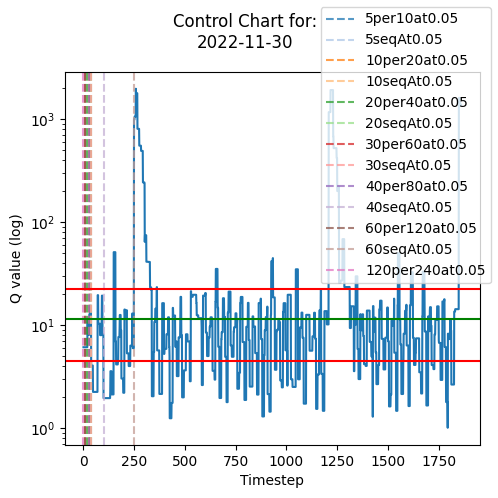

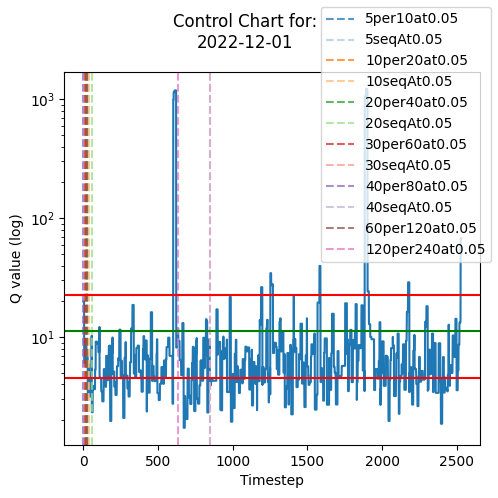

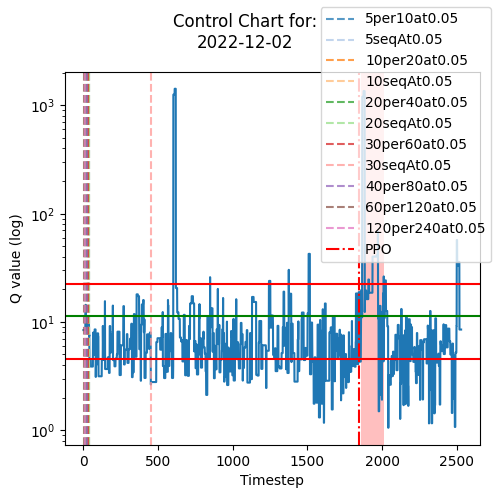

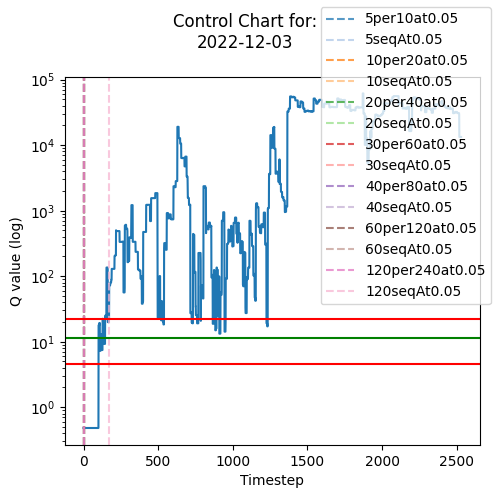

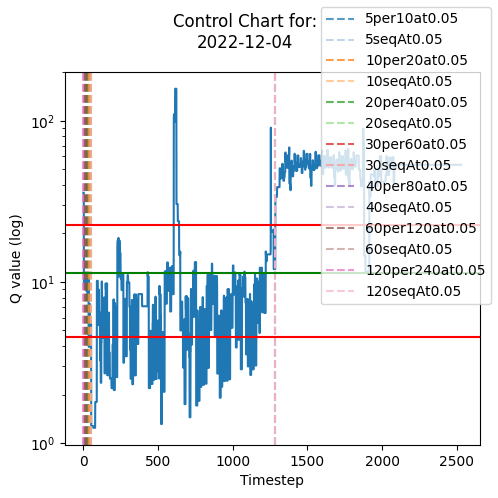

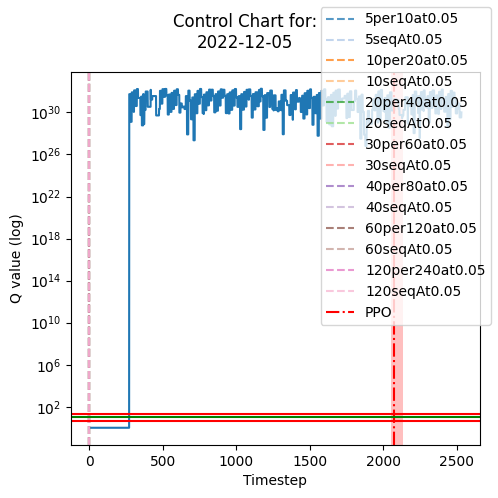

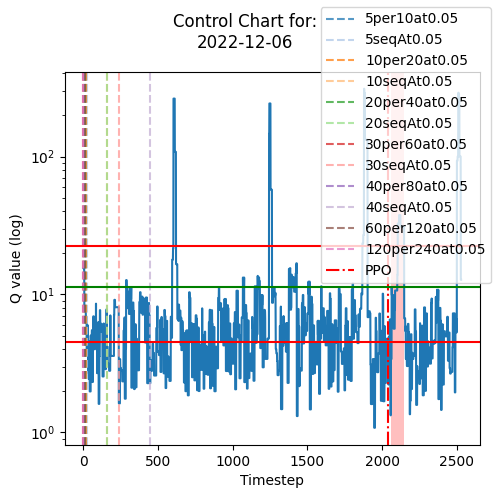

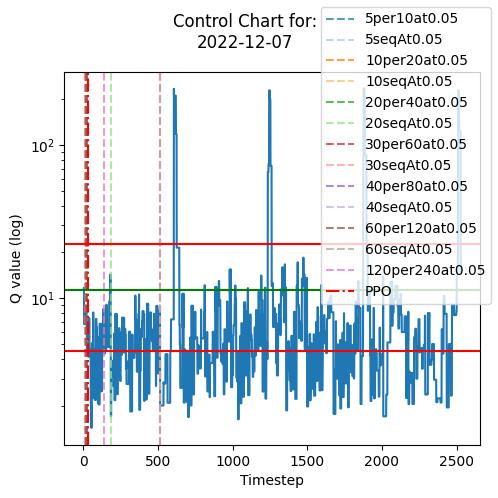

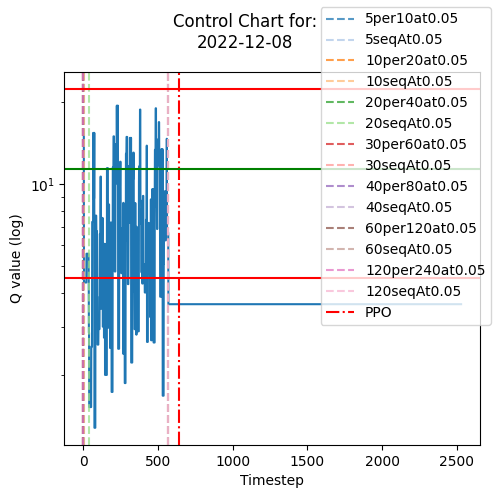

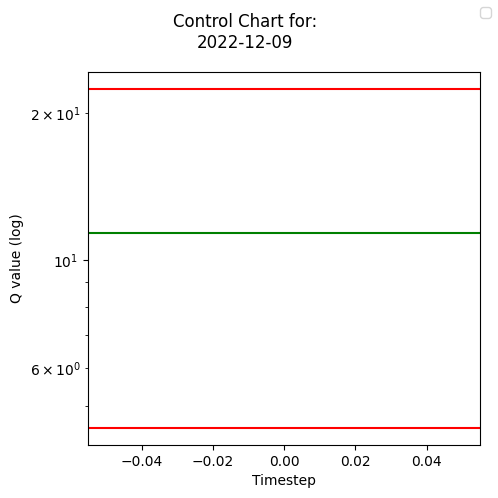

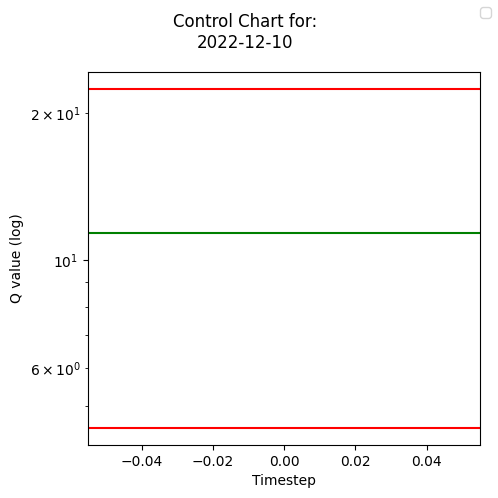

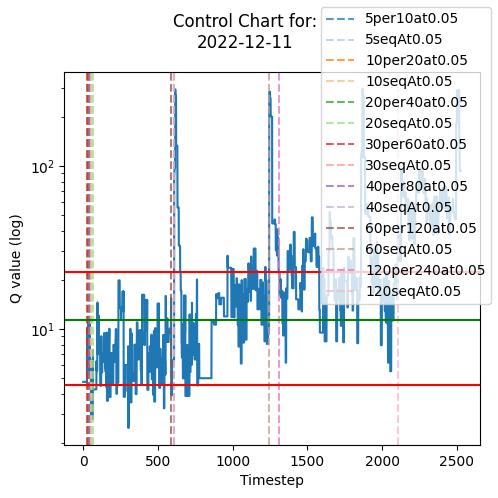

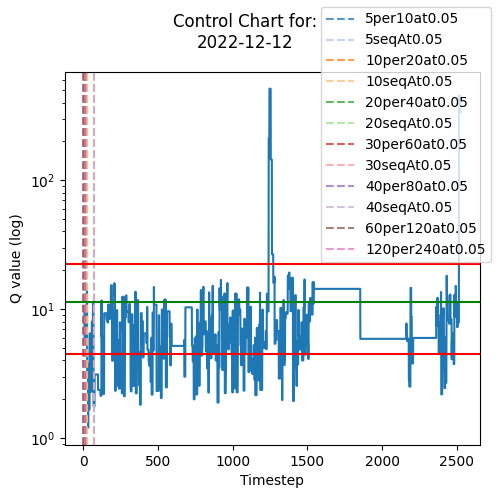

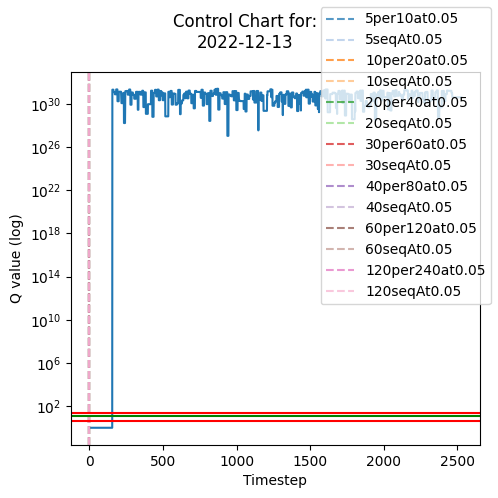

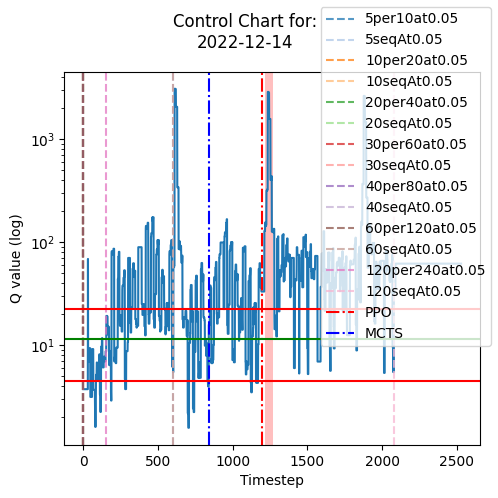

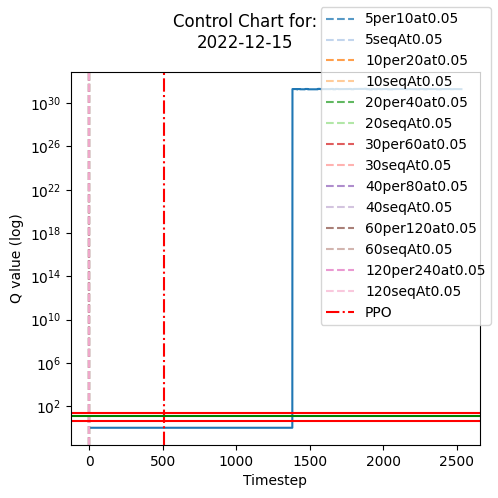

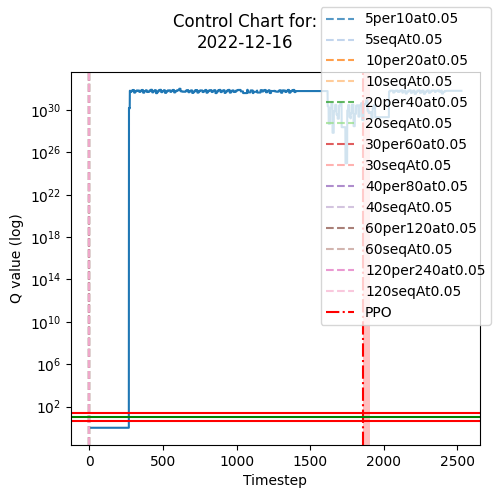

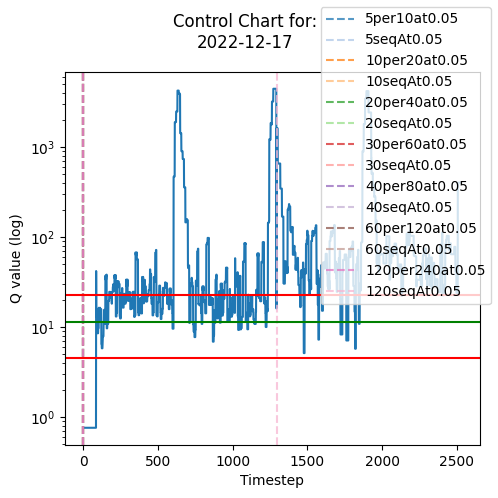

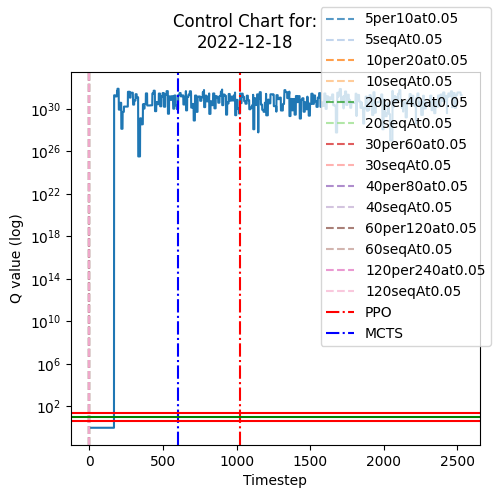

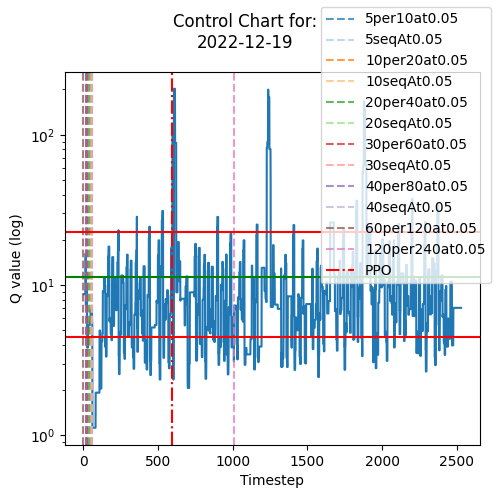

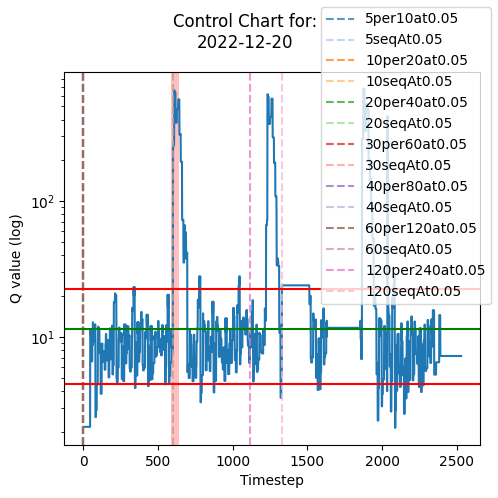

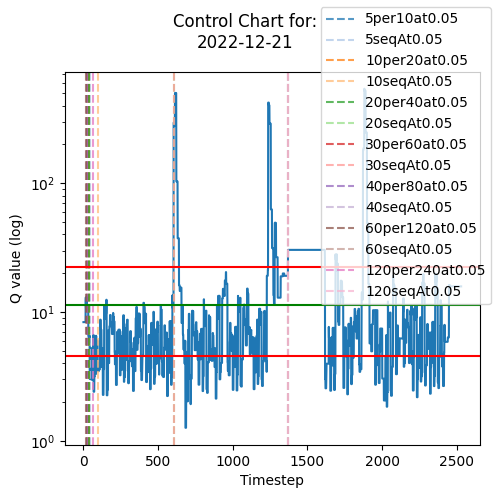

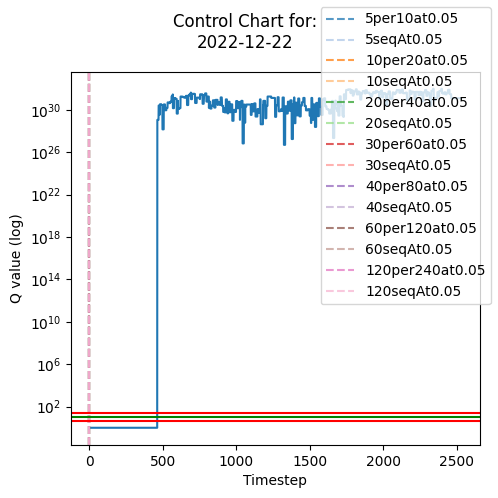

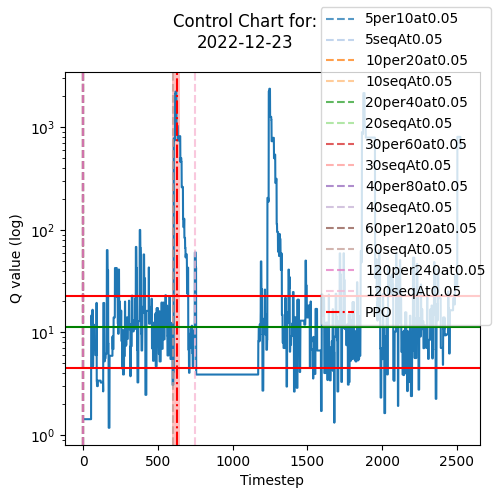

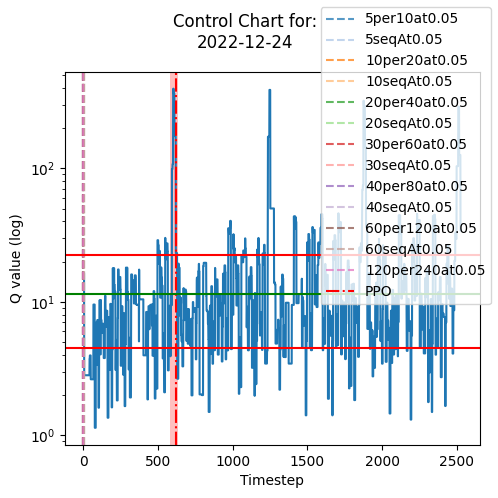

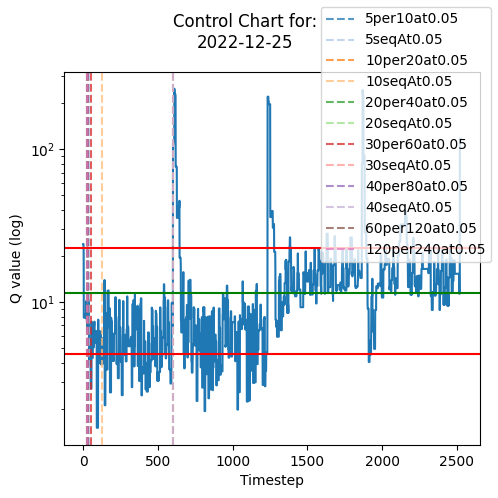

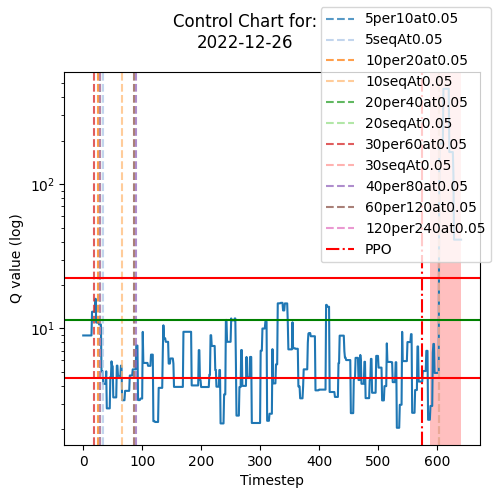

In [23]:
for nm, dset in data.items():
    np.random.seed(3942)
    print(nm.upper())

    charts = pickle.load(open(os.path.join('../results/spc/daily',nm,'charts.pkl'),'rb'))

    for i, (dt, stf) in enumerate(charts.items()):
        fig, ax = plt.subplots(
            figsize=(5,5),
            layout='tight'
        )

        chart = stf['chart']
        X = stf['X_eval'].values
        y = stf['y']
        Q = chart(stf['X_eval'].values)

        # Q plot
        sns.lineplot(
            x=range(len(Q)),
            y=Q,
        )
        # Red stop region
        try:
            start_idx = np.where(y==1)[0][0]
            end_idx = np.where(y==1)[0][-1]
            ax.axvspan(start_idx,end_idx, facecolor='red', alpha=0.25)
        except IndexError:
            start_idx = None

        patterns = dset['matches']
        # Chart stop line

        cmap = plt.cm.tab20
        cmap = [cmap(i) for i in range(len(patterns))]

        for i, (ptn, rs) in enumerate(patterns.items()):
            idx, stopped = rs[dt]

            if stopped:
                ax.axvline(idx, color=cmap[i], alpha=0.75, linestyle='--', label=ptn)

        # RL Stop lines
        if nm == 'blood-refrigerator':
            if (start_idx is None) and (np.random.rand()<0.8): 
                ppo_stop = False
                mcts_stop = False
            else:
                if start_idx is None:
                    n = len(Q)
                    start_idx = np.random.choice(range(0,n))
                if np.random.rand() < 0.9:
                    ppo_stop = start_idx - int(np.random.normal(9,30))
                else:
                    ppo_stop = False
                if np.random.rand() < 0.2:
                    mcts_stop = start_idx - int(np.random.normal(380, 40))
                else:
                    mcts_stop = False

        else:
            ppo_stop = -346
            mcts_stop = 41

        if ppo_stop:
            ax.axvline(ppo_stop, color='red', alpha=1.0, linestyle='dashdot', label='PPO')
        if mcts_stop:
            ax.axvline(mcts_stop, color='blue', alpha=1.0, linestyle='dashdot', label='MCTS')

        # Chart parameters per percentage
        for ln, c in zip([chart.lcl, chart.center_line, chart.ucl],['red','green','red']):
            ax.axhline(
                ln,
                color=c
            )
        ax.set_yscale('log')
        ax.set_xlabel('Timestep')
        ax.set_ylabel('Q value (log)')
        fig.suptitle(f'Control Chart for:\n{dt}')
        fig.legend()

        fig.savefig(
            os.path.join(IMAGE_DIR,nm,f'T-sq-cchart-{dt}.png'),
            dpi=400
        )
#        plt.close()
    break